## Práctica 7. Visualización de datos geoespaciales - Raster

Parte de esta práctica está basada en ejercicios del libro [https://www.bookdown.org/mcwimberly/gdswr-book/](https://www.bookdown.org/mcwimberly/gdswr-book/).

Se implementarán visualizaciones sobre datos capturados por distintos satélites y estaciones meteorológicas de Estados Unidos.



## (I) Variables continuas

Vamos empezar con visualizaciones de variables como la temperatura en la superficie terrestre, que, en principio, tienen un rango continuo de valores.



#### 1. Importar datos

La función `raster()` permite leer un archivo de imagen (en nuestro caso .tif) y crear un objeto "SpatRaster".



1. Descargue el archivo `MOD11A2_2017-07-12.LST_Day_1km.tif` de la carpeta de datasets a su directorio de trabajo, léalo y asígnelo al objeto lst.

In [6]:
library(sf)
library(terra)
library(ggplot2)


lst <- rast("MOD11A2_2017-07-12.LST_Day_1km.tif")

In [7]:
#Pregunta uno
dim(lst) #Sus dimensiones son 1110x3902
#! Para ver el tipo de objeto se utiliza el tipo de objeto se utuliza typeof
class(lst) #Es de objeto spatraster
st_crs(lst) #El sistema de cordenadas que usa es WGS 84

[1] 1110 3902    1

[1] "SpatRaster"
attr(,"package")
[1] "terra"

Coordinate Reference System:
  User input: WGS 84 
  wkt:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal

In [8]:
#Pregunta 2
ncell(lst) # tiene 4331220 celdas
nrow(lst) #Tiene 1110 filas
ncol(lst) #tiene 3902 columnas

[1] 4331220

[1] 1110

[1] 3902

---

**PREGUNTA 1** ¿Qué clase de objeto es lst?
¿Cuáles son las dimensiones y la resolución de este objeto? ¿Qué sistema de coordenadas utiliza?
(Ayuda: imprima el objeto)

---

---

**PREGUNTA 2** ¿Cuántas celdas tiene este objeto? Ayuda: Es un objeto rectangular.
Compruébelo invocando las funciones `ncell(), nrow(), ncol()` y compare los resultados con lo que obtuvo al imprimir el objeto

---



#### 2. Manipular datos

Un objeto SpatRaster tiene capas y cada capa tiene nombre. En nuestro caso, tiene una sola capa, las temperaturas leídas por el satélite, y el nombre de esa capa es el del archivo.  Conviene cambiar el nombre a algo más apropiado:

In [9]:
names(lst)<-c("temperatura")


Se pueden hacer operaciones aritméticas y de sumarización con los valores (píxeles) del objeto.  Por otra parte, los datos faltantes en este archivo están registrados como cero. Para poder hacer algunas operaciones aritméticas sin sesgo, es necesario transformar esos ceros en "NA".  El siguiente segmento muestra cómo hacer eso y además crea un nuevo objeto en el que la temperatura esté en grados celsius:

In [10]:
lst <- ifel(lst == 0, NA, lst)
lst_c <- lst * 0.02 - 273.15

In [11]:
global(lst_c, fun="sd", na.rm=T) #3.652
global(lst_c, fun = "mean", na.rm = T) #30.28
global(lst_c, fun = "max", na.rm = T) #54.77
global(lst_c, fun = "min", na.rm = T) #1.67



,sd
,<dbl>
temperatura,3.652403


,mean
,<dbl>
temperatura,30.28687


,max
,<dbl>
temperatura,54.77


,min
,<dbl>
temperatura,1.67


Con la función `global(objeto, fun="sd",na.rm=T)` se pueden obtener síntesis estadísticas del objeto; en el ejemplo, se calculó la desviación estándar.


---
**PREGUNTA 3.** Calcule la media,  desviación estándar, máximo y mínimo de las temperaturas del objeto.
---


#### 3. Visualización de datos raster

ggplot necesita un dataframe para poder desplegar gráficos, por lo que no podemos utilizar directamente los objetos SpatRaster. Podemos transformarlos en un dataframe con un renglón por celda y columnas para las coordenadas x y y, así como una para cada atributo asociado a cada celda,

Sin embargo, conviene resaltar que esta es una forma muy ineficiente de almacenar los datos raster, pues en general, hay muchísimas celdas contiguas idénticas.

La siguiente función permite convertir un objeto SpatRaster a un dataframe. El primer argumento es el objeto; el segundo argumento es opcional y si está presente, permite reducir la resolución  del raster antes de la conversión, lo que ayuda a reducir drásticamente el tamaño del dataframe y acelera el procesamiento.

In [12]:
rasterdf <- function(x, aggregate = 1) {
  resampleFactor <- aggregate
  inputRaster <- x
  inCols <- ncol(inputRaster)
  inRows <- nrow(inputRaster)
  # Compute numbers of columns and rows in the resampled raster
  resampledRaster <- rast(ncol=(inCols / resampleFactor),
                          nrow=(inRows / resampleFactor),
                          crs = crs(inputRaster))
  # Match to the extent of the original raster
  ext(resampledRaster) <- ext(inputRaster)
  # Resample data on the new raster
  y <- resample(inputRaster,resampledRaster,method='near')
  # Extract cell coordinates into a data frame
  coords <- xyFromCell(y, seq_len(ncell(y)))
  # Extract layer names
  dat <- stack(values(y, dataframe = TRUE))
  # Add names - 'value' for data, 'variable' for different
  # layer names in a multilayer raster
  names(dat) <- c('value', 'variable')
  dat <- cbind(coords, dat)
  dat
}

In [13]:
#Pregunta 4
df1 <-rasterdf(lst_c)
df2 <-rasterdf(lst_c,3)



In [14]:
dim(df1)
dim(df2)

summary(df1)
summary(df2)
#Las diferencias que se encuentrar es principalmente a que cuando
# El valor de la agregacion es 3 disminuyen las filas pero las variables estadisticas se comportan igual 

[1] 4331220       4

[1] 481370      4

       x                 y            value                variable      
 Min.   :-104.43   Min.   :30.0   Min.   : 1.7      temperatura:4331220  
 1st Qu.: -95.64   1st Qu.:32.5   1st Qu.:28.0                           
 Median : -86.86   Median :35.0   Median :29.5                           
 Mean   : -86.86   Mean   :35.0   Mean   :30.3                           
 3rd Qu.: -78.07   3rd Qu.:37.5   3rd Qu.:31.5                           
 Max.   : -69.28   Max.   :40.0   Max.   :54.8                           
                                  NA's   :1955616                        

       x                 y             value               variable     
 Min.   :-104.42   Min.   :30.01   Min.   :11.23    temperatura:481370  
 1st Qu.: -95.64   1st Qu.:32.50   1st Qu.:28.05                        
 Median : -86.86   Median :35.00   Median :29.55                        
 Mean   : -86.86   Mean   :35.00   Mean   :30.29                        
 3rd Qu.: -78.07   3rd Qu.:37.50   3rd Qu.:31.53                        
 Max.   : -69.29   Max.   :39.99   Max.   :54.77                        
                                   NA's   :217276                       


---
**PREGUNTA 4**  Con la función anterior,  a partir del objeto `lst_c`, genere un data frame con una agregación de 1 y a otro dataframe con una agregacion de 3.  
Compare los estadísticos de los dos dataframes invocando la función `summary()` ¿Qué diferencias encuentra?
---

Con la función `crop()` podemos recortar las celdas en el dataset raster para que cubran, por ejemplo, un área geográfica en particular.  En el siguiente ejemplo, se toman los datos dentro de un rectángulo (acotado por las latitudes y longitudes) que abarca el estado de Georgia, Estados Unidos.

In [15]:
# Crea objeto SpatExtent con la extensión geográfica
# que cubre Georgia
clipext <- ext(-86, -80.5, 30, 35.5) #Señala las coordenadas que necesita (solo las de Georgia)
class(clipext) #Lo convierte en un objeto 

# Corta las celdas correspondientes a esa extensión geográfica
lst_clip <- crop(lst_c, clipext)
# ... y crea el dataframe correspondiente
lst_clip_df <- rasterdf(lst_clip)

[1] "SpatExtent"
attr(,"package")
[1] "terra"

In [16]:
dim(lst_c) #Tiene 1110 renglones con 3902 columnas
dim(lst_clip_df) #tiene 373321 renglones con 4 columnas

[1] 1110 3902    1

[1] 373321      4

---
**PREGUNTA 5** ¿Cuántos renglones y cuántas columnas tenía el dataframe original y cuántos tiene el generado?
---
Ahora podemos visualizar los datos raster con la función `geom_raster`. La función `coord_sf` como está invocada, elimina espacios extra y las orillas del mapa



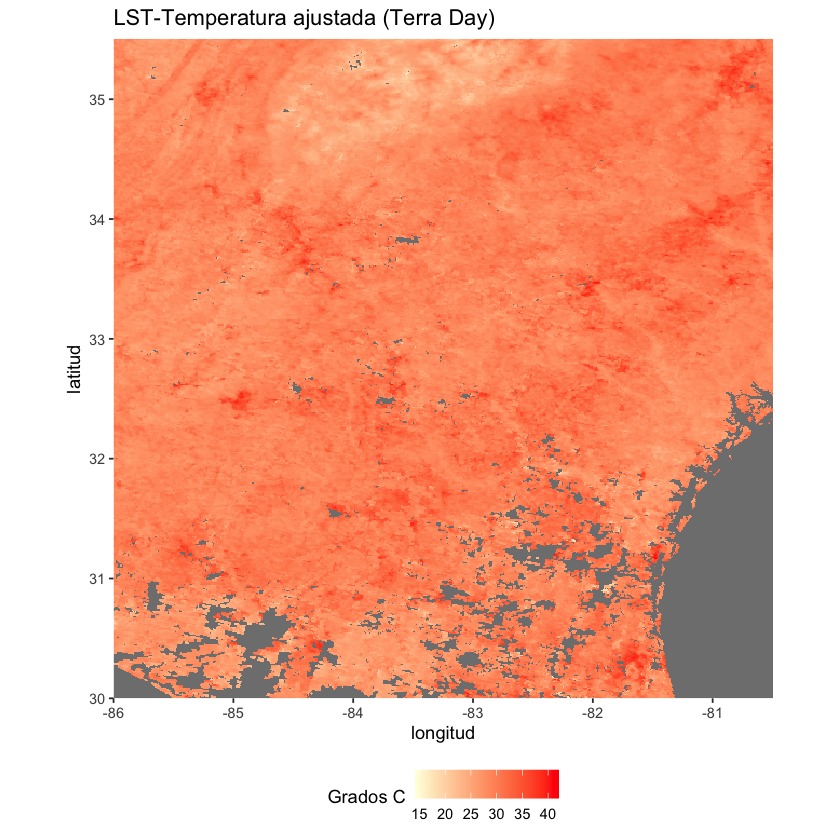

In [17]:
plot <- ggplot(data = lst_clip_df) +
  geom_raster(aes(x = x,
                  y = y,
                  fill = value)) +
  scale_fill_gradient(name = "Grados C",
                      low = "lightyellow",
                      high = "red") +
  coord_sf(expand = FALSE) +
  labs(title = "LST-Temperatura ajustada (Terra Day)",
       x = "longitud",
       y = "latitud") +
  theme(legend.position = "bottom")
plot

In [18]:
#* Pregunta 7

okcounty <- st_read("TornadosOklahoma/ok_counties.shp", quiet = TRUE)


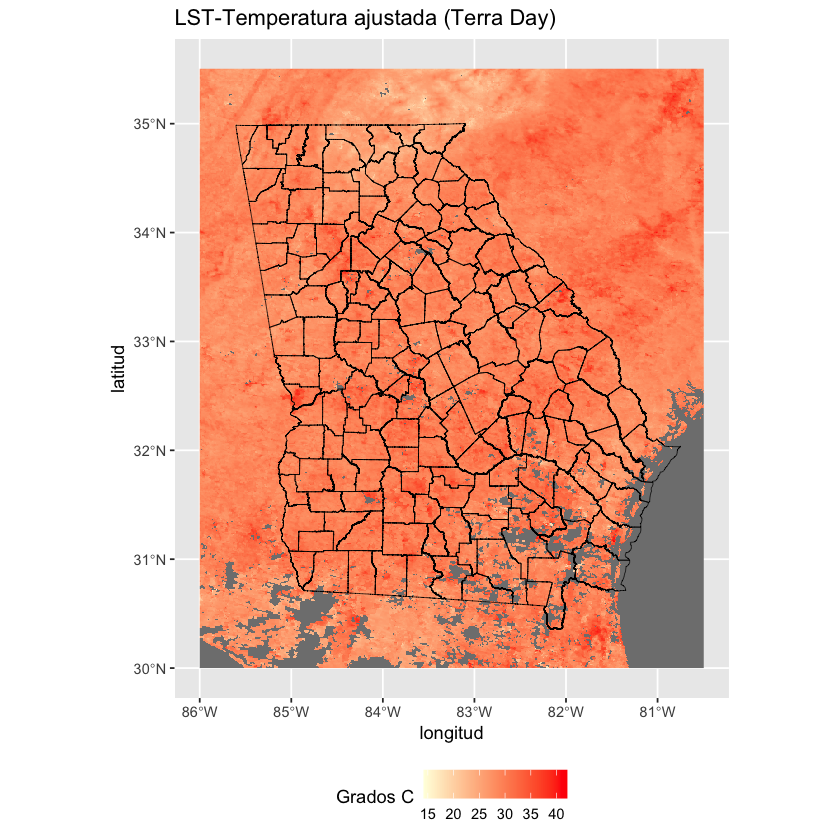

In [28]:
sf <- st_read("Testp/GA_SHP.shp", quiet = TRUE)

ggplot() +
    geom_raster(data = lst_clip_df, aes(x = x, y = y, fill = value)) +
    scale_fill_gradient(name = "Grados C", low = "lightyellow", high = "red") +
    geom_sf(data = sf, fill = NA, color = "black") + # Añade los contornos de los condados
    coord_sf(expand = FALSE) +
    labs(
        title = "LST-Temperatura ajustada (Terra Day)",
        x = "longitud",
        y = "latitud"
    ) +
    theme(legend.position = "bottom")

---
**PREGUNTA 6.** Muestre la gráfica resultante

---

Por supuesto, nos sería de gran ayuda acompañar a la visualización anterior con un mapa base que le pueda dar contexto y más sentido a la información. Afortunadamente, podemos agregar capas de datos vectoriales a nuestra visualización.  

Los archivos `GA_SHP.*` proveen los polígonos de los condados del Estado de Georgia. Descárguelos, léalos (recuerde, debe utilizar la función `st-read()`) y asigne el resultado a un objeto sf.



---

**PREGUNTA 7.** Despliegue el raster de temperaturas anterior junto con el mapa de los condados de Georgia. Para que sólo se muestre el contorno de los condados, invoque a la función que crea la capa del Estado y sus condados, con el argumento 'fill=NA'.
Muestre la gráfica resultante

---



## (II) Variables discretas

En los datasets raster las variables de interés también pueden estar codificadas como variables discretas. Por ejemplo, en vez de codificar valores (casi) continuos para temperatura, se podrían codificar una cantidad acotada de rangos de temperatura.

En esta sección trabajaremos con información de la base de datos NLCD (National Land Cover Database) de Estados Unidos, la cual toma información de imágenes satelitales y codifica las características de la superficie terrestre con valores discretos, por ejemplo, Agua=11, Bosque Perenne = 42, Cultivos = 82.

En particular, trabajaremos con una pequeña sección que corresponde al Condado Walton, en Georgia.



#### 1. Importar datos

Lea el archivo `NLCD_2019_Land_Conver_Walton.tiff` y cree un SpatRaster llamado `nlcd19`.

---

**PREGUNTA 8.** ¿Cuántos renglones, cuántas columnas y qué resolución tiene este dataset?

---

Ahora convierta el objeto en un dataframe con la función `rasterdf` y visualice el dataframe.

---

**PREGUNTA 9.** Muestre la gráfica obtenida

---

Como puede observar, este mapa es imposible de interpretar. Los valores en el objeto no son magnitudes sino datos discretos codificados.  Vamos a obtener los códigos en el dataset y vamos a crear un arreglo con los nombres apropiados para cada categoría:

In [ ]:
CodigosLC <- unique(nlcd19)[, 1]

NombresLC <-c(
  "Agua",
  "AreaDesarrolladaAbierta",
  "AreaDesarrolladaBaja",
  "AreaDesarrolladaMedia",
  "AreaDesarrolladaAlta",
  "AreaEstéril",
  "BosqueCaducifolio",
  "BosquePerenne",
  "BosqueMixto",
  "MatorralArbustos",
  "Hierba",
  "PastoHeno",
  "Cultivos",
  "Humedales",
  "VegetacionAcuaticaEmergente"
)

En los archivos tiff generados por NLCD, se incluye una tabla con los colores "oficiales" de NLCD. Se pueden extraer con la función `coltab()`. En el siguiente código, se extrae la tabla en un dataframe y se usa la función `rgb()` para convertir las escalas de rojo, verde y azul, en un valor hexadecimal.

In [ ]:
nlcdcols <- data.frame(coltab(nlcd19))
nlcdcols <- nlcdcols[CodigosLC + 1,]
ColoresLC <- rgb(red = nlcdcols$red,
                green = nlcdcols$green,
                blue = nlcdcols$blue,
                names = as.character(CodigosLC),
                maxColorValue = 255)
ColoresLC

---

**PREGUNTA 10.** ¿Qué valor hexadecimal se asignó a las superficies con código 11, 31 y 82?

---

Ahora podemos desplegar el mapa. Observe que debemos indicar en la estética de `geom_raster` que los valores son categóricos.  La función `scale_fill_manual()` nos permite asignar la paleta de colores que acabamos de crear.

In [ ]:
ggplot(data = nlcd19_df) +
  geom_raster(aes(x = x,
                  y = y,
                  fill = as.character(value))) +
  scale_fill_manual(name = "Superficie",
                    values = ColoresLC,
                    labels = NombresLC,
                    na.translate = FALSE) +
  coord_sf(expand = FALSE) +
  theme_void()


---

**PREGUNTA 11** Muestre la gráfica resultante

---

Un problema con estas visualizaciones es que no tenemos el mapa base que muestre que, efectivamente, estos datos corresponden al condado de Walton. Este condado se encuentra en el Estado de Georgia y en la sección anterior obtuvimos los polígonos de Georgia, por lo que en principio, deberíamos poder graficar nuestros datos sobre el mapa de Georgia.  

---

**PREGUNTA 12.** Inténtelo. Muestre el código y el mapa resultante

---

Seguramente no es lo que esperaba. El problema es que el mapa y los datos raster están utilizando dos sistemas de coordenadas diferentes.  Para utilizar el mismo CRS, se utiliza la función `st_transform()`:

```R
gacounty <- st_transform(ga_sf, crs(nlcd19))
```

---

**PREGUNTA 13.** Despliegue nuevamente el mapa, pero esta vez utilizando gacounty. Muestre el resultado obtenido.
¿Los datos cubren totalmente el condado?

---

Del dataframe con los polígonos, podemos seleccionar únicamente el condado de Walton:

In [ ]:
walton <-gacounty[gacounty$NAME10=="Walton",]

---
**PREGUNTA 14** Despliegue nuevamente el mapa, pero esta vez utilizando walton.
Para resaltar el contorno del condado, utilice un color negro y un tamaño de línea de 3.

Muestre el resultado obtenido.

---

Además, se puede hacer un acercamiento definiendo los límites de un rectángulo en la función `coord_sf()`:

In [ ]:
coord_sf(expand = FALSE,
           xlim = c(1144000, 1115000),
           ylim = c(1220000, 1310000))




---

**PREGUNTA 15.** Muestre el resultado obtenido.

---



---

**PREGUNTA 16.** *Esta pregunta vale 5 puntos*

Genere una gráfica como la de la figura siguiente. Suba el snippet que utilizó.

---

![](https://drive.google.com/uc?export=view&id=1L7ONQUcynwDY_ihs_KHV8lHpzV6QJfNC)



1. El archivo con las elevaciones de Puebla es `Puebla_r15m.tif`. Cárguelo y genere un objeto raster. Los datos se obtuvieron de: https://www.inegi.org.mx/app/geo2/elevacionesmex/
2. Grafíquelo con la función `plot()`.
3. Haga un dataframe a partir del objeto raster con una agregación de 10
4. En la práctica anterior generó el mapa con los Estados de México
5. Grafique el dataframe con la elevación de Puebla junto con todo el mapa de México
6. Ahora grafíquelo acotando a un rectángulo con coordenadas (-100,-96), (16,23) y ajuste la paleta de colores.